# Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.metrics import roc_curve
import tensorflow as tf
from fetch_data import get, get_KS
import sklearn

%matplotlib inline

In [2]:
# In order to run the model on GPU, we need to enable memory growth for only one GPU.
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
# read the data and split into train, validation and test

train, val, test = get(train_size=0.85, val_size=0.05, test_size=0.1)

# KNN

# CNN+LSTM

In [4]:
train_seq,train_non,train_Y=train

In [5]:
train_seq[2,:,4]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [6]:
a=[1,2,3,4]
a[1:]

[2, 3, 4]

In [7]:
def non_onehot(data,size1):
    '''
    change the one-hot into label_encoder.
    '''
    return data

In [8]:
import sklearn.preprocessing as pre

In [9]:
t = pre.OneHotEncoder()

In [10]:
train_Y=(t.fit_transform(train_Y[:,np.newaxis])).todense()

In [11]:
train_seq=non_onehot(train_seq,14)

In [12]:
train_seq.shape,train_non.shape,train_Y.shape

((3157, 60, 18), (3157, 14), (3157, 2))

In [13]:
val_seq,val_non,val_Y=val
val_seq=non_onehot(val_seq,14)
val_Y=(t.fit_transform(val_Y[:,np.newaxis])).todense()
val_seq.shape,val_non.shape,val_Y.shape

((185, 60, 18), (185, 14), (185, 2))

In [14]:
import tensorflow.keras as keras
from pyts.image import GramianAngularField as GAF
from pyts.image import MarkovTransitionField as MTF

In [15]:
from tensorflow.keras import metrics

In [16]:
from sklearn.metrics import auc, roc_curve

In [17]:
class CNN_LSTM:
    def __init__(self, data, data_non_seq, features, bins_list, size, strategy, label):
        '''
        bins_list should have the same size as features
        '''

        self.size = size
        self.strategy = strategy
        self.true_features = features
        self.bins_list = bins_list
        self.label = label

        tp_shape = data_non_seq.shape
        self.non_seq_shape = (tp_shape[1],)

        testing = self.transform_used(
            100, data, data_non_seq, label=self.label)
        tp_shape = (next(testing)[0]).shape
        self.img_shape = (tp_shape[1], tp_shape[2], tp_shape[3])

        self.CNN = self.CNN_()
        self.LSTM = self.LSTM_()
        self.non_sequential_NN = self.non_sequential_NN_()

        self.complete_model = self.whole_model()

        optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
#         optimizer=keras.optimizers.Adagrad(learning_rate=0.0001)
        self.CNN.trainable = True
        self.LSTM.trainable = True
        self.non_sequential_NN.trainable = True
        self.complete_model.compile(
            loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

        self.metrics = [0, 0, 0, 0, 0]

    def data_mtf(self, X, bins):
        mtf = MTF(image_size=self.size, n_bins=bins, strategy=self.strategy)
        mtf.fit(X)
        return mtf

    def data_gaf(self, X):
        gaf = GAF(image_size=self.size)
        gaf.fit(X)
        return gaf

    def transform_used(self, batch_size, data_used, data_non, label,
                       random_or_not=True, train=True):
        '''
        random_or_not:False, not random, True, will shuffle it
        '''
        frame_minu = np.concatenate((np.ones(shape=(
            batch_size, 1))*(1e-10), np.zeros(shape=(batch_size, data_used.shape[1]-1))), axis=-1)
        frame_minu_last = np.concatenate((np.ones(shape=(len(data_used) % batch_size, 1))*(
            1e-10), np.zeros(shape=(len(data_used) % batch_size, data_used.shape[1]-1))), axis=-1)
        if len(frame_minu_last) == 0:
            frame_minu_last = frame_minu

        X_train = np.concatenate(
            [data_used[:, :, 0][:, :, np.newaxis], data_used[:, :, 14:]], axis=-1)
        if train:
            self.fitting_frame = []
            for i in range(self.true_features):
                self.fitting_frame.append((self.data_mtf(
                    X_train[:, :, i], bins=self.bins_list[i]), self.data_gaf(X_train[:, :, i])))
        else:
            pass
        fitting_frame = self.fitting_frame

#         for epoch in range(epochs):
        whole = len(X_train)//batch_size+(len(X_train) % batch_size != 0)
        total_loss = 0

        idx = np.arange(len(data_used))
        if random_or_not:
            np.random.shuffle(idx)
        else:
            pass

        for step in range(whole):
            if step < (whole-1):
                frame_minu_ = frame_minu
            else:
                if (whole % batch_size > 0):
                    frame_minu_ = frame_minu_last
                else:
                    frame_minu_ = frame_minu

            imgs = X_train[idx[step*batch_size:(step+1)*batch_size]]
#                 get the whole transformed_data
            transformed_data = []
            for i in range(self.true_features):
                transformed_data.append(
                    fitting_frame[i][0].transform(frame_minu_+imgs[:, :, i]))
                transformed_data.append(
                    fitting_frame[i][1].transform(frame_minu_+imgs[:, :, i]))
            non_seq_data = data_non[idx[step*batch_size:(step+1)*batch_size]]
            lstm_data = data_used[:, :,
                                  1:][idx[step*batch_size:(step+1)*batch_size]]
            return_label = label[idx[step*batch_size:(step+1)*batch_size]]

            yield((np.concatenate([i[:, :, :, np.newaxis] for i in transformed_data], axis=-1)), non_seq_data, lstm_data, return_label)

    def CNN_(self):
        '''
        keras model. CNN
        '''
        dropout = 0.5
        model = keras.Sequential()
        model.add(keras.layers.Conv2D(filters=32, kernel_size=4, strides=2, padding='same', activation='relu',
                                      input_shape=self.img_shape))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
#         model.add(keras.layers.MaxPooling2D())
        model.add(keras.layers.AveragePooling2D(
            pool_size=4, strides=(2, 2), padding='same'))

        model.add(keras.layers.Conv2D(filters=16, kernel_size=2,
                                      strides=2, padding='same', activation='relu'))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
#         model.add(keras.layers.MaxPooling2D())
        model.add(keras.layers.AveragePooling2D(
            pool_size=4, strides=(2, 2), padding='same'))

        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(32, activation='relu'))

        img = keras.Input(shape=self.img_shape)
        val = model(img)

        model.summary()
        return keras.Model(img, val)

    def LSTM_(self):
        '''
        LSTM keras model, try to handel original data     
        adding 1-D convolution first


        '''
#         from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

        timesteps = 60
        n_features = 17
        model = keras.Sequential()
        model.add(keras.layers.Conv1D(filters=32, kernel_size=4, padding='same',
                                      activation='relu', strides=1, input_shape=(timesteps, n_features)))

        model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, activation="tanh",
                                                               return_sequences=True)))
#         model.add(Bidirectional(keras.layers.LSTM(128, activation="tanh", return_sequences=True)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))

        model.add(keras.layers.Bidirectional(keras.layers.LSTM(
            16, activation="tanh", return_sequences=False)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(units=32, activation="relu"))

        inp = keras.Input(shape=(timesteps, n_features))
        out = model(inp)
        model.summary()
        return keras.Model(inp, out)

    def non_sequential_NN_(self):
        '''
        Neural network for NN
        '''
        dropout = 0.5
        n_features = self.non_seq_shape
        model = keras.Sequential()
        model.add(keras.layers.Dense(
            32, activation="relu", input_shape=n_features))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))

        model.add(keras.layers.Dense(16, activation="relu"))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))

#         model.add(keras.layers.Dense(64,activation="relu"))

        inp = keras.Input(shape=n_features)
        out = model(inp)
        model.summary()
        return keras.Model(inp, out)

    def whole_model(self):
        '''
        putting all models together
        '''
        dropout = 0.5
        seq_inp = keras.Input(shape=self.img_shape)
        non_inp = keras.Input(shape=self.non_seq_shape)
        LSTM_inp = keras.Input(shape=(60, 17))

        seq = self.CNN(seq_inp)
        non_seq = self.non_sequential_NN(non_inp)
        rnn = self.LSTM(LSTM_inp)

#         model=keras.Sequential()
        concat_ = keras.layers.concatenate([seq, non_seq, rnn])
#         concat_=non_seq
        flat = keras.layers.Flatten()(concat_)
        act1 = keras.layers.Dense(128, activation="relu")(flat)
        norm1 = keras.layers.BatchNormalization()(act1)
        drop1 = keras.layers.Dropout(dropout)(norm1)

#         act2=keras.layers.Dense(64,activation="relu")(drop1)
#         drop2=keras.layers.Dropout(dropout)(act2)

        act3 = keras.layers.Dense(16, activation="relu")(drop1)
        norm3 = keras.layers.BatchNormalization()(act3)
        drop4 = keras.layers.Dropout(dropout)(norm3)

        out = keras.layers.Dense(2, activation="softmax")(drop4)

        model = keras.Model(inputs=[seq_inp, non_inp, LSTM_inp], outputs=out)
        model.summary()
        return model

    def training(self, epochs, batch_size, show_epoch, data, data_non, label,
                 val_seq, val_non, val_Y, path=None):

        data_used = data
        for epoch in range(epochs):
            gener = self.transform_used(batch_size, data, data_non, label)
            whole = len(data_used)//batch_size + \
                (len(data_used) % batch_size != 0)
            total_loss = 0
            mean_accuracy = 0

            for step in range(whole):
                imgs, non_seq_data, lstm_data, label_batch = next(gener)
                loss = self.complete_model.train_on_batch(
                    [imgs, non_seq_data, lstm_data], label_batch)
#                 self.complete_model.train_on_batch()
#                 total_loss+=(loss.loss[0]/whole)
#                 mean_accuracy+=(loss.loss[1]/whole)

            if epoch % show_epoch == 0:

                predict_prob, predict = self.model_predict(model=self.complete_model, data_seq=val_seq, data_non=val_non,
                                                           batch_size=50)
                val_acc = np.mean(predict == val_Y[:, 1])
                _, val_KS = get_KS(predict_prob[:, 1], val_Y[:, 1])
                fpr, tpr, threshold = roc_curve(
                    val_Y[:, 1], predict_prob[:, 1])
                val_auc = auc(fpr, tpr)
                self.saver(name="MTF_LSTM_NON_show1_epoch"+str(epoch)+".h5", model=self.complete_model,
                           metrics=[val_KS, val_auc])

#                 print("training on epoch: {}, loss is {}".format(epoch,total_loss))
#                 print("training on epoch: {}, accuracy is {}".format(epoch,mean_accuracy))
                print("training on epoch: {}, validation accuracy is {}".format(
                    epoch, val_acc))
                print("training on epoch: {}, validation KS is {}".format(
                    epoch, val_KS))
                print("training on epoch: {}, validation AUC is {}".format(
                    epoch, val_auc))
                print("balance_status of validation set have {} of ones in val".format(
                    np.sum(val_Y[:, 1])/len(val_Y)))

                fpr, tpr, threshold = roc_curve(
                    val_Y[:, 1], predict_prob[:, 1])
                plt.title('ROC')
                plt.plot(fpr, tpr, 'b')
                plt.legend(loc='lower right')
                plt.plot([0, 1], [0, 1], 'r--')
                plt.xlim([0, 1])
                plt.ylim([0, 1])
                plt.ylabel('True Positive Rate')
                plt.xlabel('False Positive Rate')
                plt.show()


#                 a=self.sample_images(X=X,epoch=epoch)
                print(
                    "------------generate form-------------------------------------------")
                print(
                    "--------------------------------------------------------------------")

    def saver(self, name, model, metrics=None):
        if metrics == None:
            model.save(name)
        else:
            if (metrics[0] > self.metrics[0]) and (metrics[1] > self.metrics[1]):
                model.save(name)
                self.metrics = metrics
                print(
                    "-----------------------saving models------------------------------")
            else:
                pass

    def model_predict(self, model, data_seq, data_non, batch_size):
        '''
        return prediction for using batch_size
        '''
        fake_label = np.arange(len(data_non))
        k = self.transform_used(batch_size, data_used=data_seq, data_non=data_non, label=fake_label,
                                random_or_not=False, train=False)
        store = []
        for i in range(len(data_seq)//batch_size+(len(data_seq) % batch_size != 0)):

            test_dataset = next(k)
            d0 = test_dataset[0]
            d1 = test_dataset[1]
            d2 = test_dataset[2]
#                     pay attention to the d1 d2 here. you need to adjust it
            test_predict_prob = model.predict([d0, d1, d2])
            store.append(test_predict_prob)
        store = np.concatenate(store)
        prob = store
        prediction = np.argmax(prob, axis=-1)
        return prob, prediction

In [18]:
bins_list=[10,10,10,10,10]
data=train_seq
data_non_seq=train_non
features=5
size=48
strategy="uniform"
label=train_Y
test_model=CNN_LSTM(data=data,data_non_seq=data_non_seq,features=features,bins_list=bins_list,\
                    size=size,strategy=strategy,label=train_Y)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        5152      
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          2064      
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 16)          6

No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 0, validation accuracy is 0.3585098612125639
training on epoch: 0, validation KS is 0.17298735861610115
training on epoch: 0, validation AUC is 0.5382568196939455
balance_status of validation set have 0.0972972972972973 of ones in val


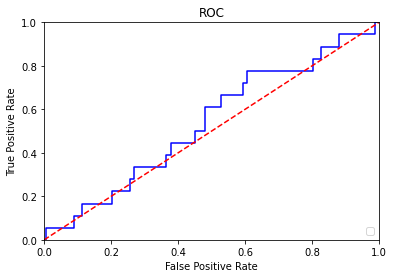

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 2, validation accuracy is 0.597954711468225
training on epoch: 2, validation KS is 0.20558882235528936
training on epoch: 2, validation AUC is 0.56187624750499
balance_status of validation set have 0.0972972972972973 of ones in val


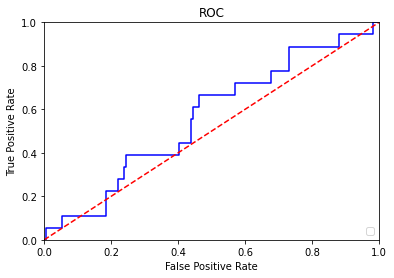

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 4, validation accuracy is 0.6458436815193572
training on epoch: 4, validation KS is 0.2977378576180971
training on epoch: 4, validation AUC is 0.5648702594810379
balance_status of validation set have 0.0972972972972973 of ones in val


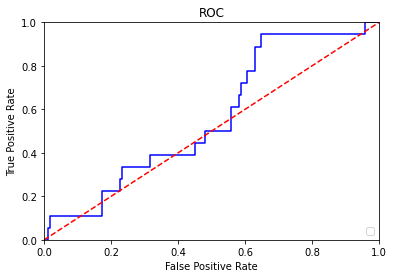

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 6, validation accuracy is 0.6153688823959095
training on epoch: 6, validation KS is 0.15202927478376582
training on epoch: 6, validation AUC is 0.5249500998003992
balance_status of validation set have 0.0972972972972973 of ones in val


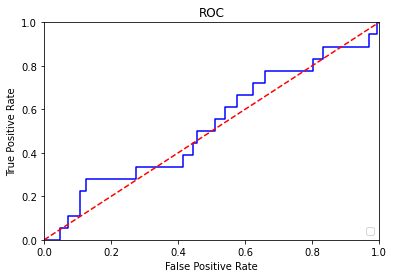

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 8, validation accuracy is 0.6284295105916727
training on epoch: 8, validation KS is 0.15668662674650702
training on epoch: 8, validation AUC is 0.4983366600133067
balance_status of validation set have 0.0972972972972973 of ones in val


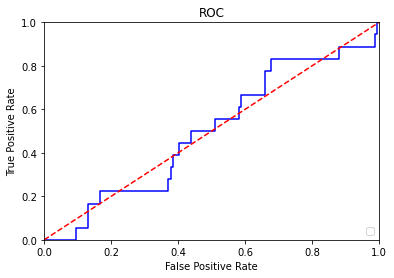

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 10, validation accuracy is 0.6850255661066472
training on epoch: 10, validation KS is 0.14471057884231542
training on epoch: 10, validation AUC is 0.48469727212242186
balance_status of validation set have 0.0972972972972973 of ones in val


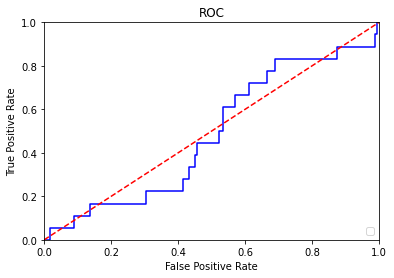

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 12, validation accuracy is 0.7111468224981738
training on epoch: 12, validation KS is 0.23453093812375259
training on epoch: 12, validation AUC is 0.4863606121091151
balance_status of validation set have 0.0972972972972973 of ones in val


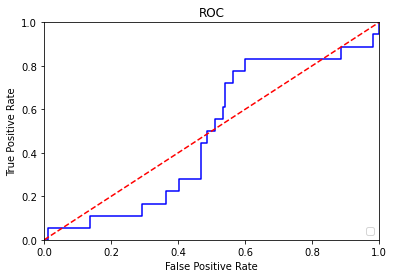

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 14, validation accuracy is 0.6937326515704894
training on epoch: 14, validation KS is 0.15668662674650702
training on epoch: 14, validation AUC is 0.4620758483033932
balance_status of validation set have 0.0972972972972973 of ones in val


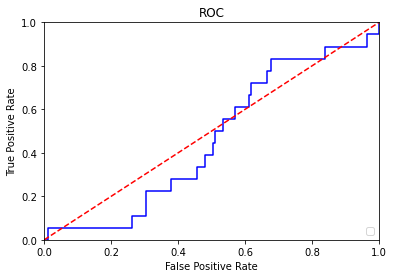

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 16, validation accuracy is 0.6937326515704894
training on epoch: 16, validation KS is 0.07884231536926156
training on epoch: 16, validation AUC is 0.4527611443779109
balance_status of validation set have 0.0972972972972973 of ones in val


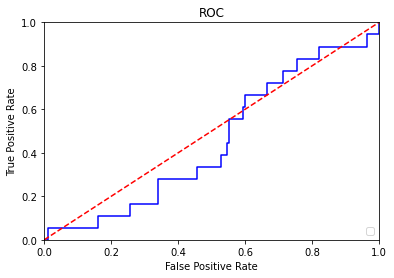

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 18, validation accuracy is 0.7503287070854638
training on epoch: 18, validation KS is 0.18230206254158343
training on epoch: 18, validation AUC is 0.47172322022621416
balance_status of validation set have 0.0972972972972973 of ones in val


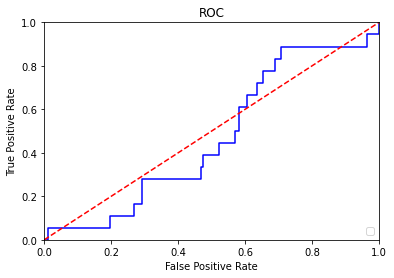

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 20, validation accuracy is 0.7633893352812272
training on epoch: 20, validation KS is 0.17032601463739183
training on epoch: 20, validation AUC is 0.4693945442448436
balance_status of validation set have 0.0972972972972973 of ones in val


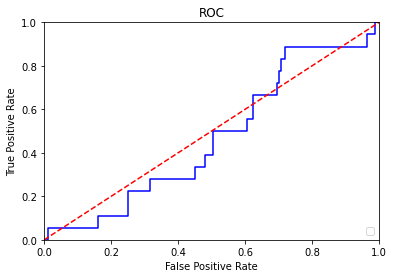

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 22, validation accuracy is 0.754682249817385
training on epoch: 22, validation KS is 0.12242182302062532
training on epoch: 22, validation AUC is 0.4723885562208915
balance_status of validation set have 0.0972972972972973 of ones in val


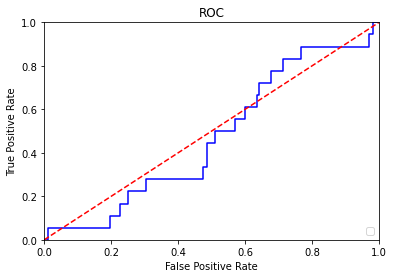

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 24, validation accuracy is 0.7242074506939372
training on epoch: 24, validation KS is 0.11743180306054557
training on epoch: 24, validation AUC is 0.44510978043912175
balance_status of validation set have 0.0972972972972973 of ones in val


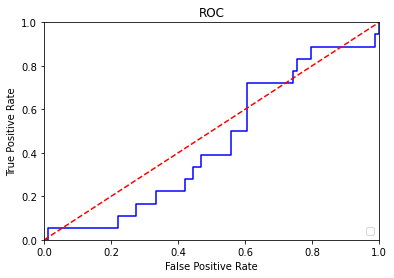

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 26, validation accuracy is 0.7198539079620161
training on epoch: 26, validation KS is 0.17032601463739183
training on epoch: 26, validation AUC is 0.4447771124417831
balance_status of validation set have 0.0972972972972973 of ones in val


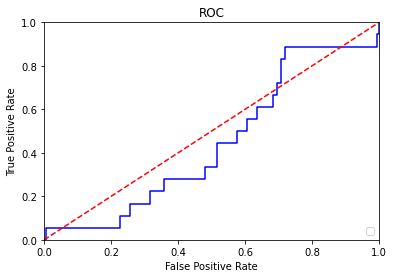

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 28, validation accuracy is 0.7329145361577794
training on epoch: 28, validation KS is 0.09248170326014638
training on epoch: 28, validation AUC is 0.4354624085163007
balance_status of validation set have 0.0972972972972973 of ones in val


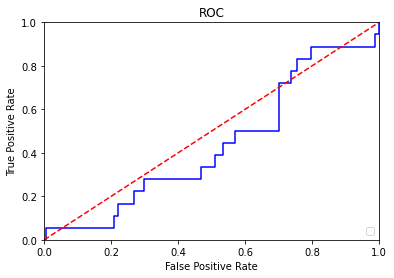

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 30, validation accuracy is 0.7372680788897005
training on epoch: 30, validation KS is 0.1087824351297405
training on epoch: 30, validation AUC is 0.4760479041916168
balance_status of validation set have 0.0972972972972973 of ones in val


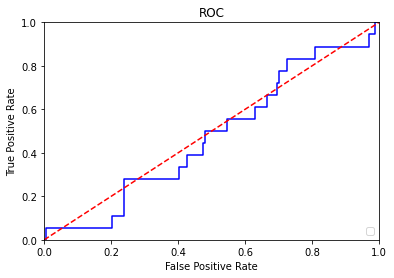

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 32, validation accuracy is 0.7764499634769905
training on epoch: 32, validation KS is 0.10545575515635397
training on epoch: 32, validation AUC is 0.4823685961410512
balance_status of validation set have 0.0972972972972973 of ones in val


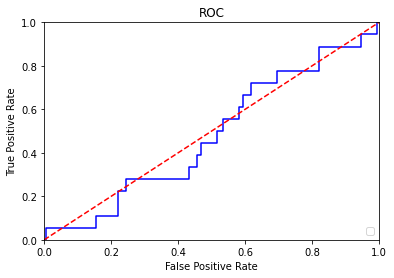

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 34, validation accuracy is 0.7764499634769905
training on epoch: 34, validation KS is 0.12341982701264143
training on epoch: 34, validation AUC is 0.48968729208250167
balance_status of validation set have 0.0972972972972973 of ones in val


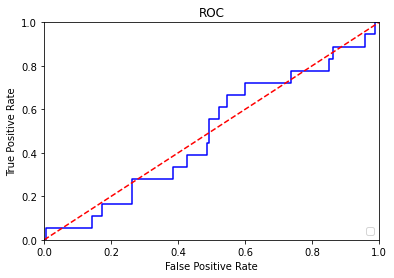

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 36, validation accuracy is 0.7851570489408327
training on epoch: 36, validation KS is 0.14903526280771795
training on epoch: 36, validation AUC is 0.48902195608782434
balance_status of validation set have 0.0972972972972973 of ones in val


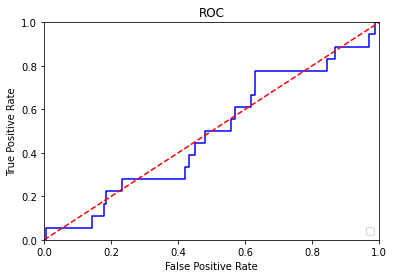

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 38, validation accuracy is 0.8025712198685172
training on epoch: 38, validation KS is 0.14471057884231542
training on epoch: 38, validation AUC is 0.4886892880904857
balance_status of validation set have 0.0972972972972973 of ones in val


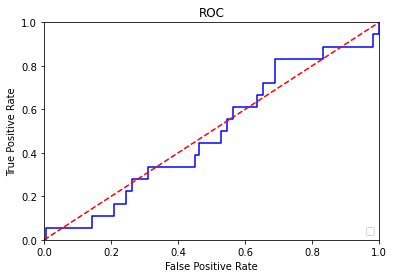

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 40, validation accuracy is 0.793864134404675
training on epoch: 40, validation KS is 0.1550232867598137
training on epoch: 40, validation AUC is 0.48303393213572854
balance_status of validation set have 0.0972972972972973 of ones in val


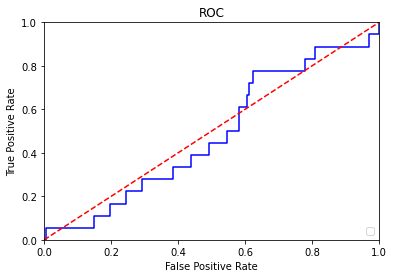

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 42, validation accuracy is 0.8069247626004383
training on epoch: 42, validation KS is 0.07984031936127745
training on epoch: 42, validation AUC is 0.4750499001996008
balance_status of validation set have 0.0972972972972973 of ones in val


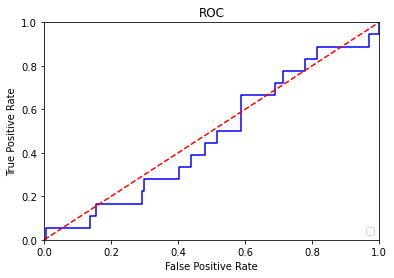

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 44, validation accuracy is 0.7982176771365961
training on epoch: 44, validation KS is 0.12840984697272118
training on epoch: 44, validation AUC is 0.5046573519627411
balance_status of validation set have 0.0972972972972973 of ones in val


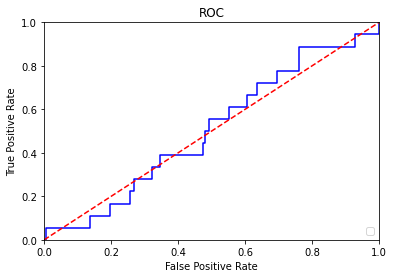

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 46, validation accuracy is 0.8069247626004383
training on epoch: 46, validation KS is 0.1217564870259481
training on epoch: 46, validation AUC is 0.49567531603459747
balance_status of validation set have 0.0972972972972973 of ones in val


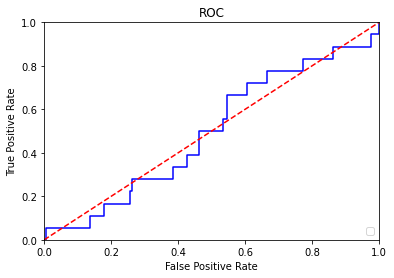

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 48, validation accuracy is 0.8025712198685172
training on epoch: 48, validation KS is 0.15602129075182974
training on epoch: 48, validation AUC is 0.5282767797737857
balance_status of validation set have 0.0972972972972973 of ones in val


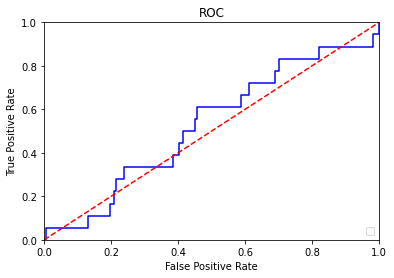

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 50, validation accuracy is 0.7982176771365961
training on epoch: 50, validation KS is 0.1320691949434465
training on epoch: 50, validation AUC is 0.5292747837658017
balance_status of validation set have 0.0972972972972973 of ones in val


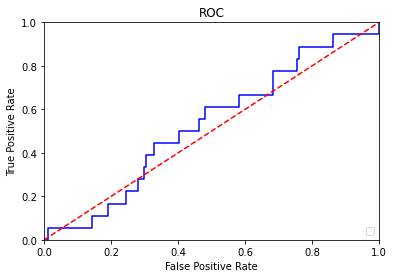

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 52, validation accuracy is 0.8069247626004383
training on epoch: 52, validation KS is 0.23819028609447773
training on epoch: 52, validation AUC is 0.5685296074517632
balance_status of validation set have 0.0972972972972973 of ones in val


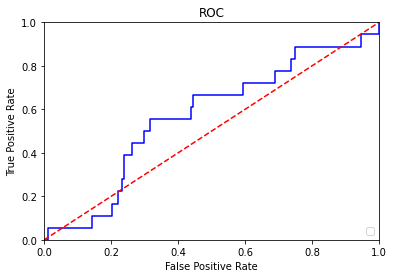

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 54, validation accuracy is 0.8199853907962016
training on epoch: 54, validation KS is 0.22022621423819033
training on epoch: 54, validation AUC is 0.5595475715236193
balance_status of validation set have 0.0972972972972973 of ones in val


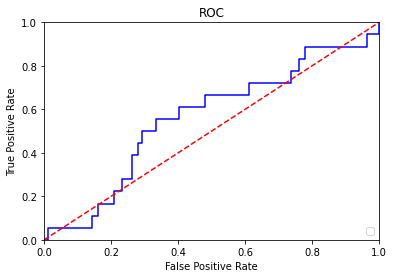

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 56, validation accuracy is 0.8286924762600438
training on epoch: 56, validation KS is 0.2235528942115768
training on epoch: 56, validation AUC is 0.5648702594810379
balance_status of validation set have 0.0972972972972973 of ones in val


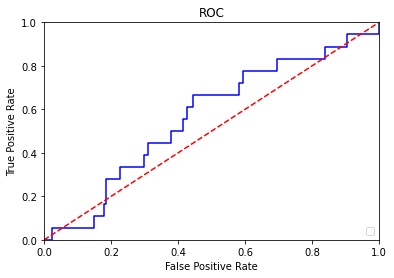

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 58, validation accuracy is 0.833046018991965
training on epoch: 58, validation KS is 0.19461077844311375
training on epoch: 58, validation AUC is 0.5592149035262808
balance_status of validation set have 0.0972972972972973 of ones in val


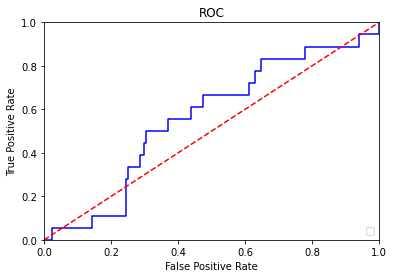

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 60, validation accuracy is 0.8548137326515705
training on epoch: 60, validation KS is 0.19860279441117767
training on epoch: 60, validation AUC is 0.5442448436460413
balance_status of validation set have 0.0972972972972973 of ones in val


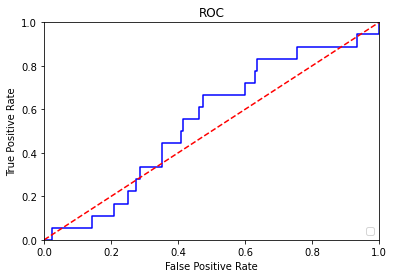

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 62, validation accuracy is 0.8504601899196493
training on epoch: 62, validation KS is 0.2029274783765802
training on epoch: 62, validation AUC is 0.5429141716566865
balance_status of validation set have 0.0972972972972973 of ones in val


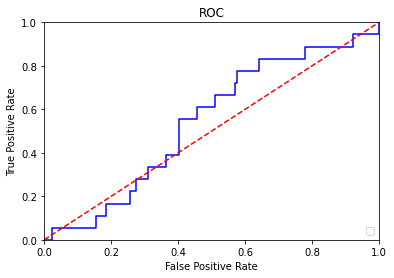

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 64, validation accuracy is 0.8504601899196493
training on epoch: 64, validation KS is 0.2149035262807718
training on epoch: 64, validation AUC is 0.5655355954757152
balance_status of validation set have 0.0972972972972973 of ones in val


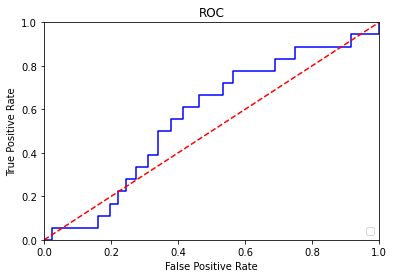

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 66, validation accuracy is 0.8548137326515705
training on epoch: 66, validation KS is 0.2628077178975383
training on epoch: 66, validation AUC is 0.5708582834331337
balance_status of validation set have 0.0972972972972973 of ones in val


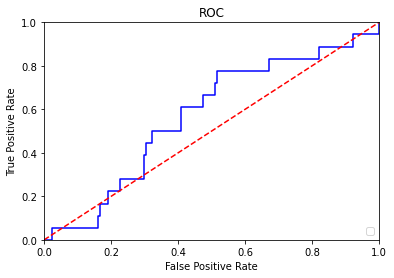

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 68, validation accuracy is 0.8548137326515705
training on epoch: 68, validation KS is 0.23386560212907526
training on epoch: 68, validation AUC is 0.5748502994011976
balance_status of validation set have 0.0972972972972973 of ones in val


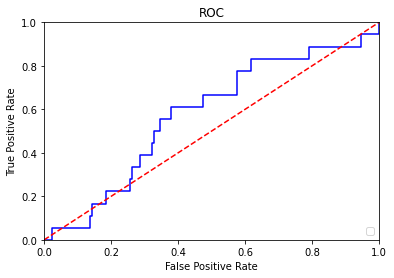

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 70, validation accuracy is 0.872227903579255
training on epoch: 70, validation KS is 0.217564870259481
training on epoch: 70, validation AUC is 0.5655355954757153
balance_status of validation set have 0.0972972972972973 of ones in val


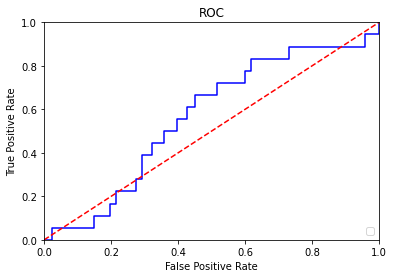

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 72, validation accuracy is 0.8852885317750183
training on epoch: 72, validation KS is 0.18330006653359943
training on epoch: 72, validation AUC is 0.555222887558217
balance_status of validation set have 0.0972972972972973 of ones in val


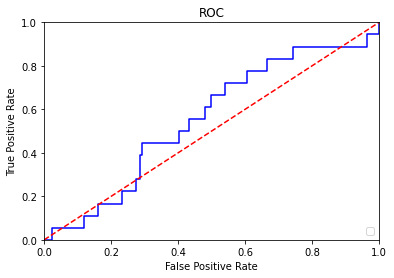

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 74, validation accuracy is 0.8809349890430972
training on epoch: 74, validation KS is 0.19527611443779103
training on epoch: 74, validation AUC is 0.5499001996007984
balance_status of validation set have 0.0972972972972973 of ones in val


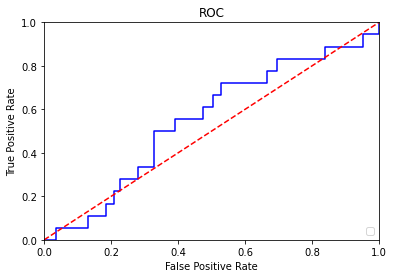

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 76, validation accuracy is 0.8896420745069393
training on epoch: 76, validation KS is 0.1190951430472389
training on epoch: 76, validation AUC is 0.5049900199600799
balance_status of validation set have 0.0972972972972973 of ones in val


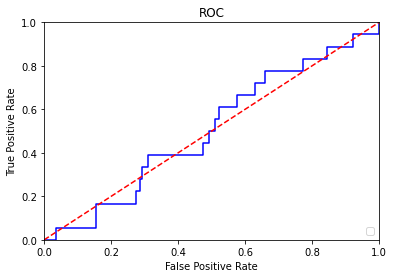

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 78, validation accuracy is 0.8809349890430972
training on epoch: 78, validation KS is 0.0968063872255489
training on epoch: 78, validation AUC is 0.5076513639387891
balance_status of validation set have 0.0972972972972973 of ones in val


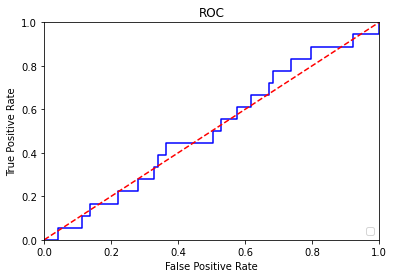

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 80, validation accuracy is 0.8852885317750183
training on epoch: 80, validation KS is 0.11244178310046576
training on epoch: 80, validation AUC is 0.5302727877578176
balance_status of validation set have 0.0972972972972973 of ones in val


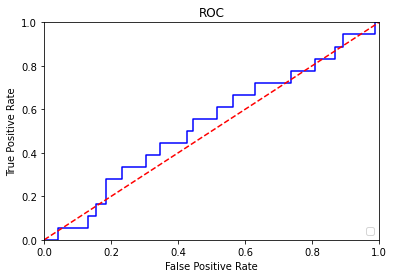

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 82, validation accuracy is 0.8896420745069393
training on epoch: 82, validation KS is 0.09347970725216237
training on epoch: 82, validation AUC is 0.4860279441117764
balance_status of validation set have 0.0972972972972973 of ones in val


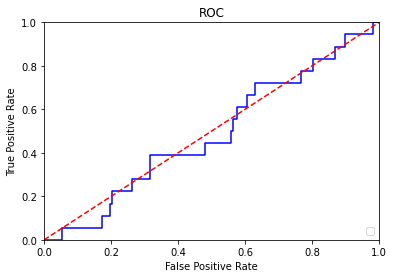

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 84, validation accuracy is 0.8896420745069393
training on epoch: 84, validation KS is 0.09081836327345316
training on epoch: 84, validation AUC is 0.5103127079174984
balance_status of validation set have 0.0972972972972973 of ones in val


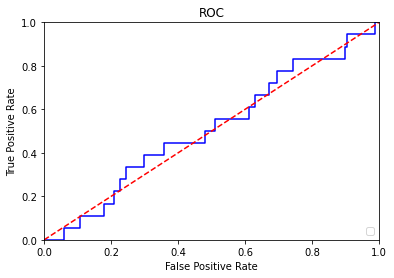

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 86, validation accuracy is 0.8983491599707816
training on epoch: 86, validation KS is 0.0119760479041916
training on epoch: 86, validation AUC is 0.4244843646041251
balance_status of validation set have 0.0972972972972973 of ones in val


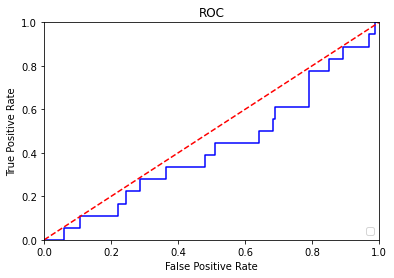

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 88, validation accuracy is 0.8983491599707816
training on epoch: 88, validation KS is 0.027278775781769793
training on epoch: 88, validation AUC is 0.4025282767797738
balance_status of validation set have 0.0972972972972973 of ones in val


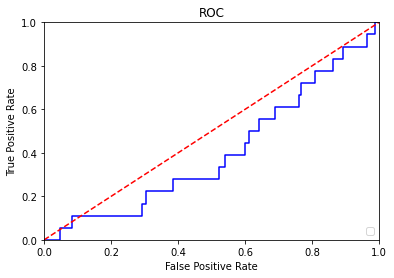

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 90, validation accuracy is 0.8939956172388605
training on epoch: 90, validation KS is 0.05056553559547572
training on epoch: 90, validation AUC is 0.39720558882235524
balance_status of validation set have 0.0972972972972973 of ones in val


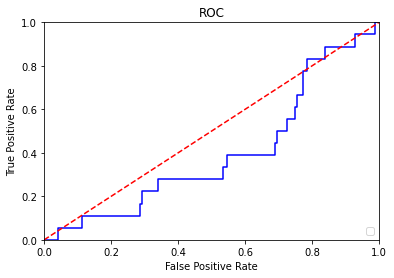

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 92, validation accuracy is 0.8983491599707816
training on epoch: 92, validation KS is 0.11477045908183636
training on epoch: 92, validation AUC is 0.4131736526946108
balance_status of validation set have 0.0972972972972973 of ones in val


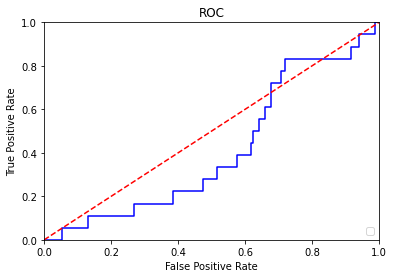

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 94, validation accuracy is 0.8939956172388605
training on epoch: 94, validation KS is 0.03093812375249505
training on epoch: 94, validation AUC is 0.4361277445109781
balance_status of validation set have 0.0972972972972973 of ones in val


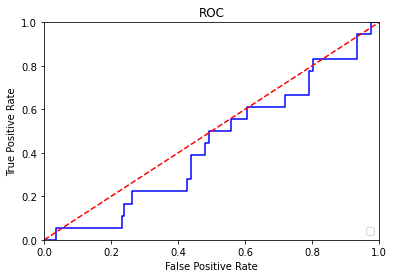

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 96, validation accuracy is 0.8896420745069393
training on epoch: 96, validation KS is 0.04790419161676651
training on epoch: 96, validation AUC is 0.447771124417831
balance_status of validation set have 0.0972972972972973 of ones in val


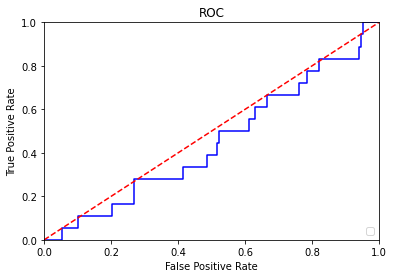

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 98, validation accuracy is 0.8896420745069393
training on epoch: 98, validation KS is 0.05788423153692612
training on epoch: 98, validation AUC is 0.4441117764471058
balance_status of validation set have 0.0972972972972973 of ones in val


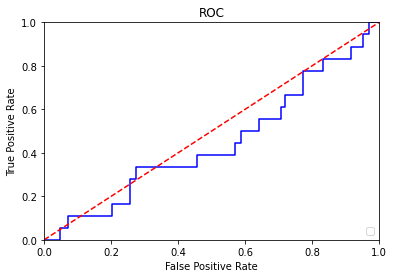

------------generate form-------------------------------------------
--------------------------------------------------------------------


In [19]:
test_model.training(epochs=100,batch_size=1000,show_epoch=2,data=data,data_non=data_non_seq,label=train_Y\
                   ,val_seq=val_seq,val_non=val_non,val_Y=val_Y)

In [20]:
test_seq,test_non,test_Y=test
test_seq=non_onehot(test_seq,14)
test_Y=(t.fit_transform(test_Y[:,np.newaxis])).todense()
test_seq.shape,test_non.shape,test_Y.shape

((371, 60, 18), (371, 14), (371, 2))

In [21]:
# YY_prob.shape

In [22]:
# YY_prob=test_model.non_sequential_NN.predict(test_non)
# np.sum(YY_prob,axis=-1)

In [23]:
# np.sum(YY_prob)

In [24]:
73338.695

73338.695

In [25]:
# YL_prob=test_model.LSTM.predict(test_seq)
# np.sum(YL_prob,axis=-1)

In [26]:
# np.sum(YL_prob)

In [27]:
k=test_model.transform_used(50,data_used=test_seq,data_non=test_non,label=train_Y,\
                            random_or_not=False,train=False)
store=[]
for i in range(len(test_seq)//50+(len(test_seq)%50!=0)):
    test_dataset=next(k)
    d0=test_dataset[0]
    d1=test_dataset[1]
    d2=test_dataset[2]
    test_predict_prob=test_model.complete_model.predict([d0,d1,d2])
    store.append(test_predict_prob)
store=np.concatenate(store,axis=0)
test_predict_prob=store
test_predict=np.argmax(test_predict_prob,axis=-1)
acc=np.mean(test_predict==test_Y[:,1])
test_ks=get_KS(test_predict_prob[:,1],test_Y[:,1])
acc,test_ks

(0.9050646246394606, (0.37860206, 0.10054701745246153))

In [28]:
fpr,tpr,threshold=roc_curve(test_Y[:,1],test_predict_prob[:,1])
val_auc=auc(fpr,tpr)
val_auc

0.4683511331075801

No handles with labels found to put in legend.


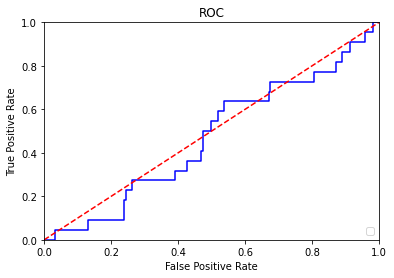

In [29]:
fpr, tpr, threshold = roc_curve(test_Y[:,1],test_predict_prob[:,1])                
plt.title('ROC')
plt.plot(fpr, tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
